In [432]:
import cv2
import numpy as np
import math
from google.colab.patches import cv2_imshow

In [433]:
# Quantization Matrix from page 125 reference book
Q_MAT = np.array([[16,11,10,16,24,40,51,61],
                [12,12,14,19,26,58,60,55],
                [14,13,16,24,40,57,69,56],
                [14,17,22,29,51,87,80,62],
                [18,22,37,56,68,109,103,77],
                [24,35,55,64,81,104,113,92],
                [49,64,78,87,103,121,120,101],
                [72,92,95,98,112,100,103,99]])

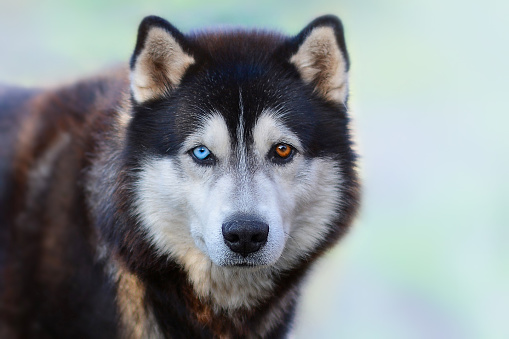

In [434]:
img = cv2.imread('husky.jpeg')
cv2_imshow(img)

In [435]:
img.shape

(339, 509, 3)

In [436]:
def zigzag(input):
    h, v, vmin, hmin = 0, 0, 0, 0
    vmax, hmax = input.shape[0], input.shape[1]
    i = 0
    output = np.zeros((vmax * hmax))

    while ((v < vmax) and (h < hmax)):
        if ((h + v) % 2) == 0:
            if (v == vmin):
                output[i] = input[v, h]
                if (h == hmax):
                    v += 1
                else:
                    h += 1
                i += 1
            
            elif ((h == hmax - 1) and (v < vmax)):
                output[i] = input[v, h]
                v += 1
                i += 1
            
            elif ((v > vmin) and (h < hmax -1)):
                output[i] = input[v, h]
                v -= 1
                h += 1
                i += 1
        
        else:
            if ((v == vmax - 1) and (h <= hmax - 1)):
                output[i] = input[v, h]
                h += 1
                i += 1
            elif (h == hmin):
                output[i] = input[v, h]
                if (v == vmax -1):
                    h += 1
                else:
                    v += 1
                i += 1
            elif ((v < vmax - 1) and (h > hmin)):
                output[i] = input[v, h]
                v += 1
                h -= 1
                i += 1

        if ((v == vmax - 1) and (h == hmax - 1)):
            output[i] = input[v, h]
            break

    return output

In [437]:
def inverse_zigzag(input, vmax, hmax):
	h, v, vmin, hmin = 0, 0, 0, 0
	output = np.zeros((vmax, hmax))
	i = 0
	while ((v < vmax) and (h < hmax)): 
		if ((h + v) % 2) == 0:
			if (v == vmin):				
				output[v, h] = input[i]
				if (h == hmax):
					v += 1
				else:
					h += 1                        

				i += 1
			elif ((h == hmax -1 ) and (v < vmax)):
				output[v, h] = input[i] 
				v += 1
				i += 1

			elif ((v > vmin) and (h < hmax -1 )):
				output[v, h] = input[i] 
				v -= 1
				h += 1
				i += 1
		else:
			if ((v == vmax - 1) and (h <= hmax - 1)):
				output[v, h] = input[i] 
				h += 1
				i += 1
        
			elif (h == hmin):
				output[v, h] = input[i] 
				if (v == vmax -1):
					h += 1
				else:
					v += 1
				i += 1
        		        		
			elif((v < vmax - 1) and (h > hmin)):
				output[v, h] = input[i] 
				v += 1
				h -= 1
				i += 1

		if ((v == vmax - 1) and (h == hmax - 1)):
			output[v, h] = input[i] 
			break


	return output


In [438]:
block_size = 8
h, w, c = img.shape
height = h
width = w
h = np.float32(h) 
w = np.float32(w) 
# number of blocks in height
nbh = np.int32(math.ceil(h/block_size))
# and in width
nbw = np.int32(math.ceil(w/block_size))

In [439]:
def encode(padded_img):
    for i in range(nbh):
            # Compute start and end row index of the block
            row_ind_s = i * block_size
            row_ind_e = row_ind_s + block_size
            
            for j in range(nbw):
                # Compute start and end row index of the block
                col_ind_s = j * block_size
                col_ind_e = col_ind_s + block_size
                
                # Choose block
                block = padded_img[row_ind_s : row_ind_e, col_ind_s : col_ind_e]

                # apply 2D discrete cosine transform to the "block" and normalize
                DCT = cv2.dct(block)
                DCT_normalized = np.divide(DCT, Q_MAT).astype(int)    
                
                # reorder DCT coefficients in zig-zag order
                reordered = zigzag(DCT)
                reshaped = np.reshape(reordered, (block_size, block_size))
                
                # Copy reshaped matrix into padded_img
                padded_img[row_ind_s : row_ind_e, col_ind_s : col_ind_e] = reshaped
        
    return padded_img

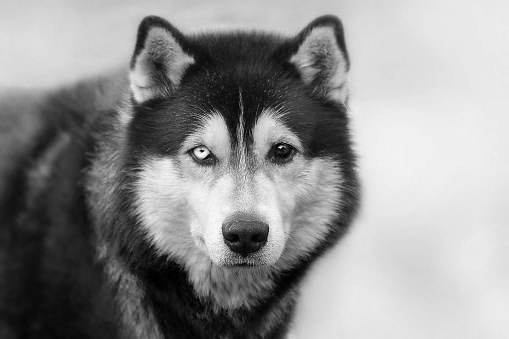

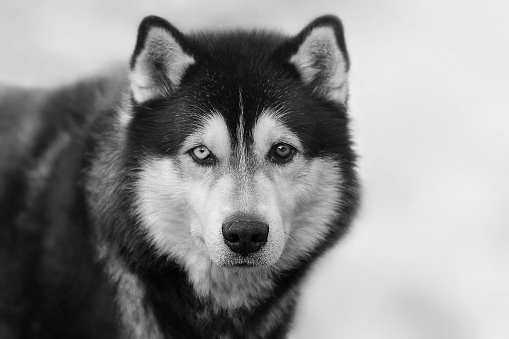

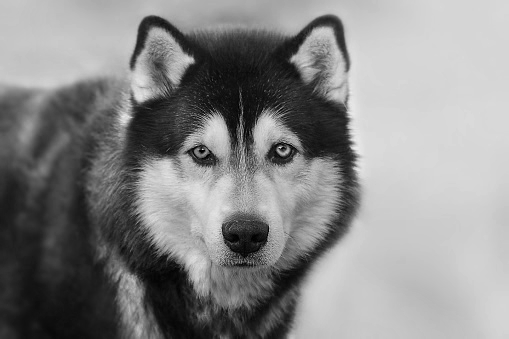

In [440]:
b, g, r = cv2.split(img)
cv2_imshow(np.uint8(b))
cv2_imshow(np.uint8(g))
cv2_imshow(np.uint8(r))

In [441]:
# padded image height
pih =  block_size * nbh
# and width
piw =  block_size * nbw

# create a numpy zero matrix with size of H, W and copy the values of img to padded_img[0:h,0:w]
padded_img_r = np.zeros((pih, piw))
padded_img_r[0:height, 0:width] = r[0:height, 0:width]

padded_img_g = np.zeros((pih, piw))
padded_img_g[0:height, 0:width] = g[0:height, 0:width]

padded_img_b = np.zeros((pih, piw))
padded_img_b[0:height, 0:width] = b[0:height, 0:width]

padded_img = cv2.merge((padded_img_b, padded_img_g, padded_img_r))

padded_img_b.shape

(344, 512)

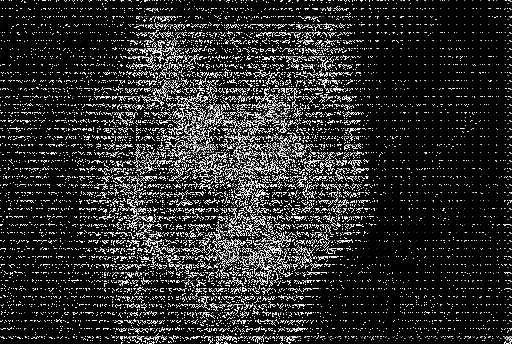

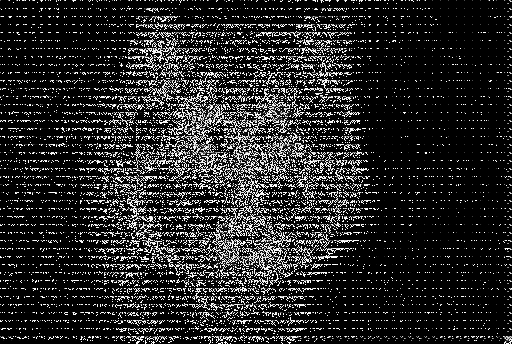

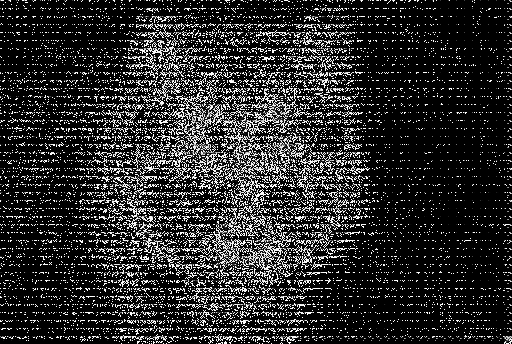

In [442]:
encoded_img_r = encode(padded_img_r)
encoded_img_g = encode(padded_img_g)
encoded_img_b = encode(padded_img_b)

cv2_imshow(np.uint8(encoded_img_r))
cv2_imshow(np.uint8(encoded_img_g))
cv2_imshow(np.uint8(encoded_img_b))

In [443]:
encoded_img_r.shape

(344, 512)

# **Encoding**

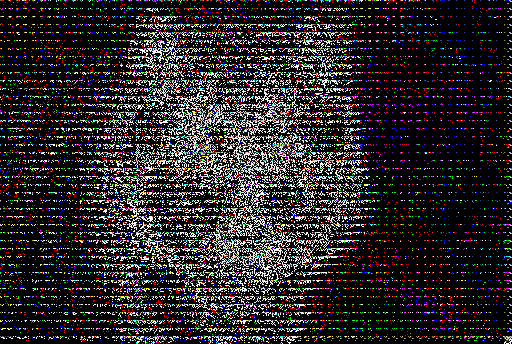

In [444]:
# merge RGB
encoded_img = cv2.merge((encoded_img_r, encoded_img_g, encoded_img_b))
cv2_imshow(np.uint8(encoded_img))

In [445]:
encoded_img.shape

(344, 512, 3)

In [446]:
# Calculating zero elements/whole elements
whole_count = encoded_img.shape[0] * encoded_img.shape[1] * encoded_img.shape[2]
zero_count = whole_count - np.count_nonzero(encoded_img)
thinning = zero_count/whole_count

print("Zero Count/Whole Count =", zero_count, "/", whole_count, "=", thinning)

Zero Count/Whole Count = 54826 / 528384 = 0.1037616581879845


In [454]:
# Calculating model error
diff = cv2.absdiff(padded_img, encoded_img)
norm_diff = cv2.norm(diff, cv2.NORM_L2)
norm_img = cv2.norm(padded_img, cv2.NORM_L2)
distortion = (norm_diff * norm_diff) / (norm_img * norm_img)
print("Difference norm: ", norm_diff, "~", round(norm_diff))
print("Distortion: ", distortion, '~', round(distortion))

Difference norm:  154733.24439926722 ~ 154733
Distortion:  1.7479540448508522 ~ 2


we didn't expect anything more, what we are comparing encoded and original image, obviously they shouldn't be similar

In [448]:
np.savetxt('encodedr.txt', encoded_img_r)
np.savetxt('encodedg.txt', encoded_img_g)
np.savetxt('encodedb.txt', encoded_img_b)

np.savetxt('size.txt',[h, w, block_size])

#**Decoding**

In [449]:
# load 'encodedx.txt' into padded_img_x matrix.
padded_img_r = np.loadtxt('encodedr.txt')
padded_img_g = np.loadtxt('encodedg.txt')
padded_img_b = np.loadtxt('encodedb.txt')

# load 'size.txt' to get [h, w, block_size]
[h, w, block_size] = np.loadtxt('size.txt')


[H, W] = padded_img_r.shape

# number of blocks in height and width
nbh = np.int32(math.ceil(h/block_size))
nbw = np.int32(math.ceil(w/block_size))

In [450]:
def decode(padded_img):
    for i in range(nbh):
            row_ind_1 = i * int(block_size)
            row_ind_2 = row_ind_1+int(block_size)

            for j in range(nbw):
                col_ind_1 = j * int(block_size)
                col_ind_2 = col_ind_1+int(block_size)
                block = padded_img[ row_ind_1 : row_ind_2 , col_ind_1 : col_ind_2 ]

                # reshape the 2D block (here: 8-by-8) to one dimensional array (here: 64)
                reshaped= np.reshape(block,(int(block_size)*int(block_size)))##### your code #####

                # use inverse_zigzag function to scan and reorder the array into a block
                reordered = inverse_zigzag(reshaped, int(block_size), int(block_size))##### your code #####

                # apply 2D inverse discrete cosine transform to the reordered matrix
                IDCT = cv2.idct(reordered)##### your code #####

                # copy IDCT matrix into padded_img on current block corresponding indices
                padded_img[ row_ind_1 : row_ind_2 , col_ind_1 : col_ind_2 ] = IDCT##### your code #####
    return padded_img

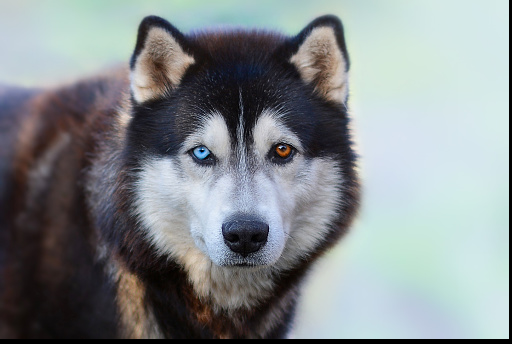

In [451]:
decoded_img_r = decode(padded_img_r)
decoded_img_g = decode(padded_img_g)
decoded_img_b = decode(padded_img_b)

decoded_img = cv2.merge((decoded_img_b, decoded_img_g, decoded_img_r))

decoded_img_original = decoded_img[0:int(h),0:int(w), 0:3]

cv2_imshow(decoded_img)

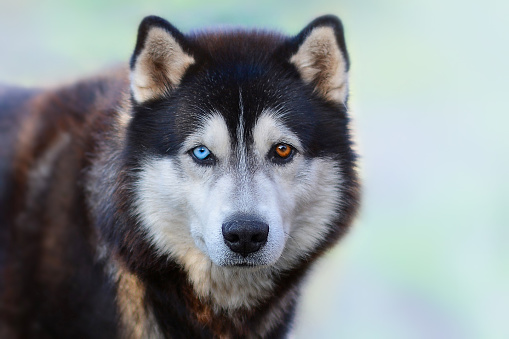

In [452]:
cv2_imshow(img)

In [453]:
diff = cv2.absdiff(padded_img, decoded_img)
norm_diff = cv2.norm(diff, cv2.NORM_L2)
norm_img = cv2.norm(padded_img, cv2.NORM_L2)
distortion = (norm_diff * norm_diff) / (norm_img * norm_img)
print("Difference norm", norm_diff, "~", round(norm_diff))
print("Distortion:", distortion, "~", round(distortion))

Difference norm 3.8371106047877625e-11 ~ 0
Distortion: 1.0749082169015044e-31 ~ 0
